In [73]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator

In [74]:

#### initial state
n=4
#parameters: w1,w2=0.5   e1,e2=+/-1     cs=1   u=0.2   
# x=w1(1+e1*u/cs^2) = 0.6         equation 3 link 1
# y=w2(1+e2*u/cs^2) = 0.4         equation 3 link 2
x = 0.6
y = 0.4


# lambda1= x +/- i Sqrt(1-x^2)      
# lambda2= y +/- i Sqrt(1-y^2)         
# positive for C1, negative for C2

lambda1 = np.round(np.log(complex(x, np.sqrt(1-x**2))), 10)
lambda2 = np.round(np.log(complex(y, np.sqrt(1-y**2))), 10)


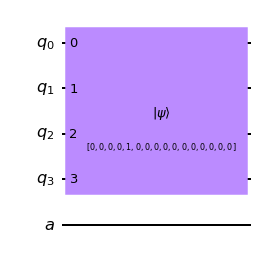

In [79]:
#####set up circuit
classicalState = np.zeros(n**2)
classicalState[4] = 1

q = QuantumRegister(n,'q')
a = AncillaRegister(1,'a')

qc = QuantumCircuit(q)
qc.initialize(classicalState)
qc.add_register(a)

qc.draw()

# collision steps


In [80]:
def createC(lambda1, lambda2, isC1 = True):
    
    if not isC1:
        lambda1=np.conj(lambda1)
        lambda2=np.conj(lambda2)
    
    lambda1=lambda1.imag#temporary
    lambda2=lambda2.imag#temporary
    
    qc=QuantumCircuit(2)
    
    #phase1 -> x -> phase1 -> x -----ctrl=0
    qc.cp(lambda1, 0 ,1 , ctrl_state = 0)
    qc.cx(0, 1, ctrl_state = 0)
    qc.cp(lambda1, 0, 1, ctrl_state = 0)
    qc.cx(0, 1, ctrl_state = 0)
    
    #phase2 -> x -> phase2 -> x -----ctrl=1 is default
    qc.cp(lambda2, 0, 1)
    qc.cx(0, 1)
    qc.cp(lambda2, 0, 1)
    qc.cx(0, 1)
    
    return qc

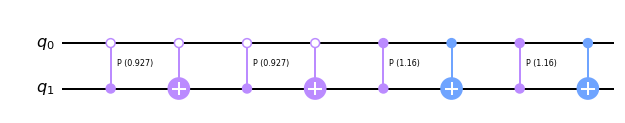

In [81]:
C1 = createC(lambda1, lambda2, True)
c1gate = C1.to_gate(label = 'c1')
C1.draw()

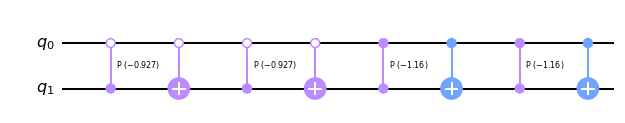

In [82]:
C2 = createC(lambda1, lambda2, False)
c2gate = C2.to_gate(label = 'c2')
C2.draw()

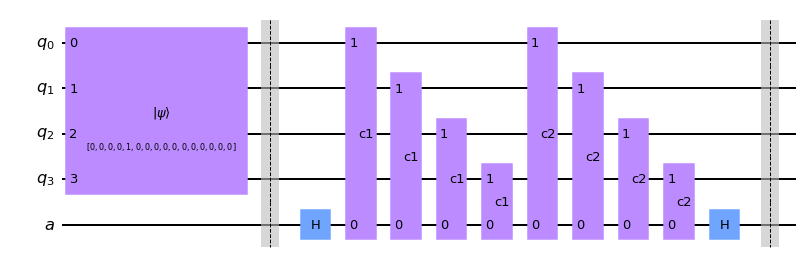

In [83]:
######adding steps to circuit

qc.barrier()
qc.h(a)

##c1 and c2 act on every qubit controlled on ancilla
for i in range(4):
    qc.append(c1gate,[a,i])
for i in range(4):
    qc.append(c2gate,[a,i])

qc.h(a)
qc.barrier()
qc.draw()

# left and right shifts

In [84]:
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ
R = rshift(n).to_gate(label = "R").control(1, ctrl_state = 0)
L = lshift(n).to_gate(label = "L").control(1, ctrl_state = 1)

In [85]:
tmp = [a]
tmp.extend([i for i in range(n)])

qc.append(R,tmp)
qc.append(L,tmp)
qc.barrier()

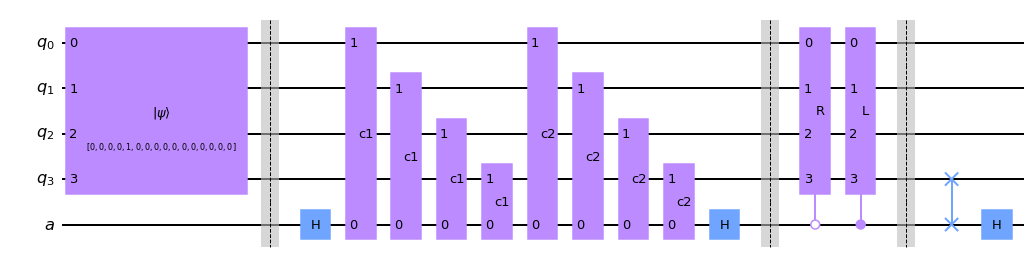

In [87]:
qc.swap(a,n-1)
qc.h(a)
qc.draw()